# **Rough Volatility**
---

- Copyright (c) Antoine Jacquier (QuantLearn Ltd), 2022. All rights reserved

- Author: Antoine Jacquier <Jack.QuantLearn@gmail.com>

- Platform: Tested on Windows 10 with Python 3.9

### The time series of realised variance

- Assuming an underlying variance process $v_s$, integrated variance $\frac 1 \delta \,\int_t^{t+\delta}\,v_s\,ds$ may (in principle) be estimated arbitrarily accurately given enough price data.

    - In practice, market microstructure noise makes estimation harder at very high frequency.
    - Sophisticated estimators of integrated variance have been developed to adjust for market microstructure noise.  See Gatheral and Oomen <sup id="cite_ref-GO" class="reference"><a href="#cite_note-GO"><span>[</span>10<span>]</span></a></sup> (for example) for details of these.


- The Oxford-Man Institute of Quantitative Finance makes historical realized variance (RV) estimates freely available at http://realized.oxford-man.ox.ac.uk.  These estimates are updated daily.

    - Each day, for 21 different indices, all trades and quotes are used to estimate realized (or integrated) variance over the trading day from open to close.



- Using daily RV estimates as proxies for instantaneous variance, we may investigate the time series properties of $v_t$ empirically.




First update and save the latest Oxford-Man data:

In [1]:
import warnings; warnings.simplefilter('ignore')
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile as zi
from io import StringIO, BytesIO
from scipy import stats
from sklearn.linear_model import LinearRegression
import requests
import urllib
%matplotlib inline
plt.style.use('seaborn-darkgrid')
from scipy.stats import norm

In [ ]:
url = 'https://realized.oxford-man.ox.ac.uk/images/oxfordmanrealizedvolatilityindices-0.2-final.zip'
data = requests.get(url, stream=True).content
z = zi.ZipFile(BytesIO(data))
z.extractall()

df = pd.read_csv('OxfordManRealizedVolatilityIndices.csv', index_col=0, header=2 )
rv1 = pd.DataFrame(index=df.index)
for col in df.columns:
    if col[-3:] == '.rk':
        rv1[col] = df[col]
rv1.index = [dt.datetime.strptime(str(date), "%Y%m%d") for date in rv1.index.values]
rv1 = rv1.dropna()
rv1.head()

We only extract the realised variance estimators computed via realised kernel, which are denoted by ".rk".

#### SPX Time Series

##### Importing the SPX

We can get the corresponding SPX data from the CBOE website directly (see also the SPXHistory notebook)

In [3]:
url  = r'http://www.cboe.com/micro/buywrite/dailypricehistory.xls'
spx = pd.read_excel(url)#, index_col=0, header=0, parse_dates=True)
spx = spx.drop(spx.index[:4])
spx = spx[[spx.columns[0], spx.columns[3]]]
spx.rename(columns={spx.columns[0]:'Date', 'Unnamed: 3': 'SPX'}, inplace=True)
spx.set_index('Date', inplace=True)
spx['SPX'] = spx['SPX'].apply(pd.to_numeric) ## make sure the SPX data is really of Float type
spx = spx[:-25]
#spx.index = pd.DatetimeIndex(data=spx.index)
spx.index = pd.to_datetime(spx.index, errors='coerce')
spx.head()

,SPX
Date,
1986-06-30,250.84
1986-07-01,252.04
1986-07-02,252.70
1986-07-03,251.79
1986-07-07,244.05


##### Adding the variance time series

In [4]:
spx["RV"] = rv1['SPX2.rk']
spx["Returns"] = spx["SPX"].pct_change(1)
spx = spx.dropna()
spx.head()

,SPX,RV,Returns
Date,,,
2002-07-08,976.98,0.000199,-0.012184
2002-07-10,920.47,0.000355,-0.033962
2002-07-11,927.37,0.000630,0.007496
2002-07-12,921.39,0.000438,-0.006448
2002-07-15,917.93,0.000583,-0.003755


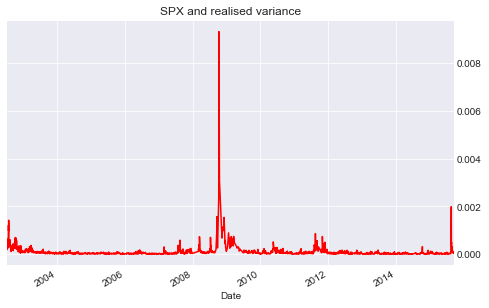

In [5]:
#spx["SPX"].plot(color='blue', grid=True, label='SPX',figsize=(8, 5));
spx["RV"].plot(color='red', grid=True, label='SPX realised variance',figsize=(8, 5), secondary_y =True);
plt.title("SPX and realised variance");

###Smoothness of the volatility process


For $q\geq 0$, we define the $q$th sample moment of differences of log-volatility at a given lag $\Delta$.
($\langle\cdot\rangle$ denotes the sample average):
$$
m(q,\Delta):=\langle\left|\log \sigma_{t+\Delta}^2 -\log \sigma_{t}^2 \right|^q\rangle.
$$


###Scaling of $m(q,\Delta)$ with lag $\Delta$

In [6]:
nbDeltas = 20
lags = np.linspace(1., 300., nbDeltas, dtype=int)
#qq = np.array([0.5, 1., 1.5, 2., 3., ])
qq = np.array([0.5, 1., 3., 4., 5.])
nq = len(qq)

In [7]:
def mqd(col, q, ll):
    return [np.log(pow(abs(np.log(rv1[col]) - np.log(rv1[col].shift(l))), q)).mean() for l in ll]

#### Choose the index

In [8]:
col = rv1.columns[0]
print("Index: ", col)

Index:  SPX2.rk


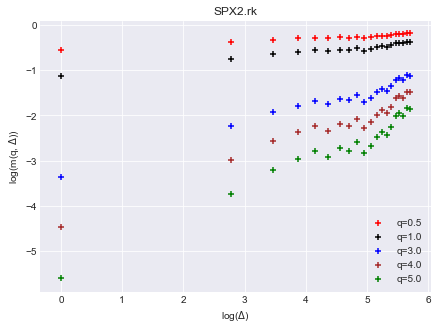

In [9]:
plt.figure(figsize=(7,5))
colors = ['red', 'black', 'blue', 'brown', 'green']
mqds = []
for i in range(nq):
    mqds.append(mqd(col, qq[i], lags))
    plt.scatter(np.log(lags), mqds[-1], marker="+", c=colors[i], label="q=%.1f" %qq[i])
plt.legend(loc=4)
plt.xlabel("log($\Delta$)")
plt.ylabel("log(m(q, $\Delta$))")
plt.title(col)
plt.show()

##### Linear fit

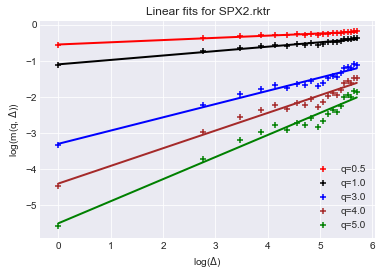

,intercept,Coef
q,,
0.5,-0.551033,0.061191
1.0,-1.102067,0.122382
3.0,-3.306200,0.367145
4.0,-4.408267,0.489526
5.0,-5.510334,0.611908


In [10]:
regrInterc, regrCoef = np.zeros(nq), np.zeros(nq)
logLagsx = np.log(lags).reshape(-1, 1)
colors = ['red', 'black', 'blue', 'brown', 'green']
for i in range(nq):
    y = np.array(mqds[i]).reshape(-1, 1)
    regr = LinearRegression()
    regr.fit(logLagsx,y)
    regrCoef[i] = regr.coef_[0][0]
    regrInterc[i] = regr.intercept_[0]
    plt.scatter(logLagsx,y, marker="+", c=colors[i], label="q=%.1f" %qq[i])
    plt.plot(logLagsx,regr.predict(logLagsx), c=colors[i], linewidth=2)

plt.legend(loc=4, fontsize=10)
plt.xlabel("log($\Delta$)")
plt.ylabel("log(m(q, $\Delta$))")
plt.title("Linear fits for %str" %col)
plt.show()

linearFitsDF = pd.DataFrame(index=qq)
linearFitsDF["intercept"] = regrInterc
linearFitsDF["Coef"] = regrCoef
linearFitsDF.index.name = "q"
linearFitsDF.head()

###Monofractal scaling result

- From the above log-log plot, we see that for each $q$, $m(q,\Delta) \approx \Delta ^{\zeta_q}$.


- How does $\zeta_q$ scale with $q$?

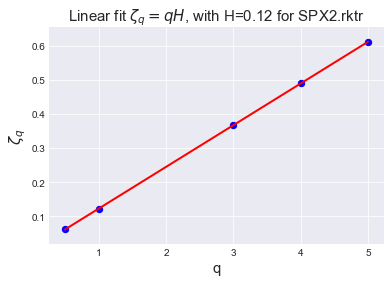

In [11]:
qqx, y = qq.reshape(-1, 1), regrCoef.reshape(-1, 1)
regr = LinearRegression()
regr.fit(qqx,y)
plt.scatter(qqx,y, marker="o", s=40, c='blue')
plt.plot(qqx,regr.predict(qqx), 'r', linewidth=2)
plt.xlabel("q", fontsize=15)
plt.ylabel("$\zeta_q$", fontsize=15)
plt.title("Linear fit $\zeta_q = qH$, with H=%.2f for %str" %(regr.coef_[0][0], col), fontsize=15)
plt.show()

###Testing over a longer range of powers $q$

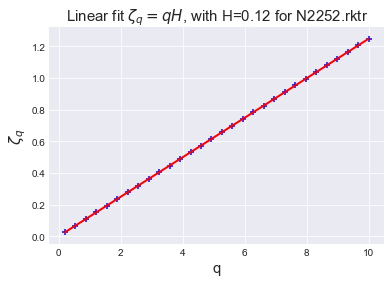

In [12]:
col = rv1.columns[2]
qq = np.linspace(0.2, 10., 30)
nq = len(qq)
mqds = []
for i in range(nq):
    mqds.append(mqd(col, qq[i], lags))

regrInterc, regrCoef = np.zeros(nq), np.zeros(nq)
logLagsx = np.log(lags).reshape(-1, 1)
for i in range(nq):
    y = np.array(mqds[i]).reshape(-1, 1)
    regr = LinearRegression()
    regr.fit(logLagsx,y)
    regrCoef[i] = regr.coef_[0][0]
    regrInterc[i] = regr.intercept_[0]

linearFitsDF = pd.DataFrame(index=qq)
linearFitsDF["intercept"] = regrInterc
linearFitsDF["Coef"] = regrCoef
linearFitsDF.index.name = "q"
qqx, y = qq.reshape(-1, 1), regrCoef.reshape(-1, 1)
regr = LinearRegression()
regr.fit(qqx,y)
plt.scatter(qqx,y, marker="+", s=30, c='blue')
plt.plot(qqx,regr.predict(qqx), 'r', linewidth=2)
plt.xlabel("q", fontsize=15)
plt.ylabel("$\zeta_q$", fontsize=15)
plt.title("Linear fit $\zeta_q = qH$, with H=%.2f for %str" %(regr.coef_[0][0], col), fontsize=15)
plt.show()
#print regr.coef_[0][0], regr.intercept_[0]

###Estimated $H$ for all indices

We now repeat this analysis for all 21 indices in the Oxford-Man dataset.
We only use $q=2$, and compute the optimal H as well as the constant.

We consider the model 
$$
\sigma_t = \exp(\nu W_t^H),
$$
where $W^H$ is a fractional Brownian motion with Hurst parameter $H \in (0,1)$ and $\nu>0$ the volatility of volatility parameter.
With $q=2$, can therefore compute
$$
m(2, \Delta) = \mathbb{E}\left[\left|\log\left(\sigma^2_{t+\Delta}\right) - \log\left(\sigma^2_{t}\right)\right|^2\right]
 = 2\nu^2\mathbb{E}\left[\left|W_{t+\Delta}^H - W_{t}^H\right|^2\right].
$$
Since
$$
\mathbb{E}\left[\left|W_{t+\Delta}^H - W_{t}^H\right|^2\right]
= \mathbb{E}\left[\left|W_{t+\Delta}^H\right|^2\right] + \mathbb{E}\left[\left|W_{t}^H\right|^2\right] - 2\mathbb{E}\left[W_{t+\Delta}^HW_{t+\Delta}^H\right]
 = \Delta^{2H},
$$
we therefore deduce that
$$
\log m(2, \Delta) = 2H\log(\Delta) + \log(2\nu^2).
$$
We therefore perform a linear regression of $\log m(2, \Delta)$ against $\log(\Delta)$ to estimate the coefficients $H$ and $\nu$.

In [13]:
optimalH, optimalnu = [], []

q = 2.
for col in rv1.columns:
    try:
        mqds = mqd(col, q, lags)
        regr = LinearRegression()
        regr.fit(logLagsx,np.array(mqds).reshape(-1, 1))
        optimalH.append(0.5*regr.coef_[0][0])
        optimalnu.append(np.sqrt(0.5*np.exp(regr.intercept_[0])))
    except:
        optimalH.append("NaN")
        optimalnu.append("NaN")

dataCoefdf = {"Name": rv1.columns, "H": optimalH, "nu": optimalnu}
Coefdf = pd.DataFrame(data=dataCoefdf)
Coefdf

,Name,H,nu
0,SPX2.rk,0.122382,0.234889
1,FTSE2.rk,0.185662,0.166111
2,N2252.rk,0.124666,0.216761
3,GDAXI2.rk,0.179872,0.178941
4,RUT2.rk,NaN,NaN
5,AORD2.rk,0.0927671,0.259713
6,DJI2.rk,0.12572,0.223957
7,IXIC2.rk,0.131955,0.196635
8,FCHI2.rk,0.157774,0.192024
9,HSI2.rk,0.115488,0.1936


The value of H seems to be consistent throughout all indices.

#### What about the distribution of $(\log \sigma_{t+\Delta}-\log \sigma_t)$?

In [15]:
def plotScaling(col, llags):
    ## llags : array of lags (in days)
    
    def xDel(x, lag):
        return x - x.shift(lag)
    
    def sdl(lag):
        return (xDel(np.log(rv1[col]), lag)).std()
    
    sd1 = (xDel(np.log(rv1[col]), 1)).std()
    h = Coefdf.loc[Coefdf["Name"] == col]["H"].values[0]
    f, ax = plt.subplots(1,len(llags),sharex=False, sharey=False, figsize=(15, 5))   
    
    for i in range(len(llags)):
        la = llags[i]
        hist_val = xDel(np.log(rv1[col]), la).dropna()
        
        k2, p = stats.normaltest(hist_val)
        ax[i].set_title('%str ; Lag = %s Days' %(col, la))
        n, bins, patches = ax[i].hist(hist_val.values, bins=100,normed=1, facecolor='green',alpha=0.2)
        #.hist(bins=20)
        ax[i].plot(bins, norm.pdf(bins,hist_val.mean(),hist_val.std()), "r")
        ax[i].plot(bins, norm.pdf(bins,hist_val.mean(),sd1 * la ** h), "b--") ## scaling
        height = 1. / (hist_val.std()*np.sqrt(2.*np.pi))
        right = max(hist_val)
        ax[i].text(0.6*right,height,"pval=%.1E" %p, horizontalalignment='center',verticalalignment='center')
        ax[i].set_xlim([min(hist_val), max(hist_val)])
        hist_val.plot(kind='density', ax=ax[i])

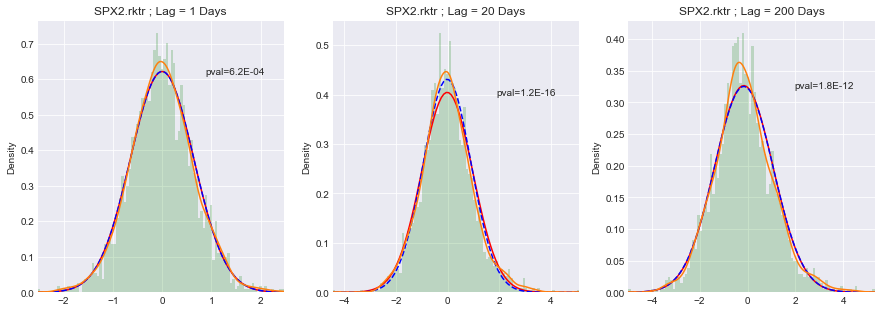

In [18]:
col = rv1.columns[0]
llags = [1, 20, 200] ## in days
plotScaling(col,llags)

### Summary: A natural model of realised volatility

- Distributions of differences in the log of realized volatility are close to Gaussian.

    - This motivates us to model $\sigma_t$ as a lognormal random variable.


- Moreover, the scaling property of variance of RV differences suggests the model:

<a name="eq:dataDriven"></a>(1)
$$
\log \sigma_{t+\Delta} - \log \sigma_t =\nu\,\left( W^H_{t+\Delta}-W^H_t\right)
$$
where $W^H$ is fractional Brownian motion.

### Remark: Is it the same for the stock price?

In [19]:
spx["returns"] = spx["SPX"].pct_change(1)
def mqdspx(q, ll):
    return [np.log(pow(abs(np.log(spx["returns"]) - np.log(spx["returns"].shift(l))), q)).mean() for l in ll]

nbDeltas = 100
lags = np.linspace(1., 100., nbDeltas, dtype=int)
qq = np.array([0.5, 1., 1.5, 2., 3.])
nq = len(qq)

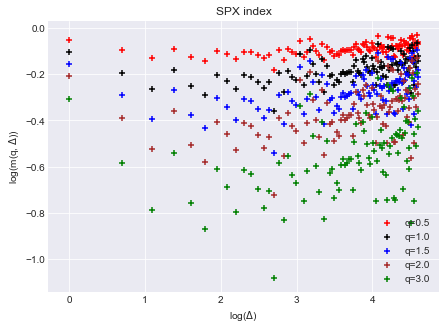

In [20]:
plt.figure(figsize=(7,5))
colors = ['red', 'black', 'blue', 'brown', 'green']
mqds = []
for i in range(nq):
    mqds.append(mqdspx(qq[i], lags))
    plt.scatter(np.log(lags), mqds[-1], marker="+", c=colors[i], label="q=%.1f" %qq[i])
plt.legend(loc=4)
plt.xlabel("log($\Delta$)")
plt.ylabel("log(m(q, $\Delta$))")
plt.title("SPX index")
plt.show()

Not really convincing for the index itself (actually reassuring...)

# Fractional Brownian motion

- *Fractional Brownian motion* (fBm) $\{W^H_t; t \in \mathbb{R}\}$ is the unique Gaussian process with mean zero and autocovariance function
$$
\mathbb{E}\left[W^H_t W^H_s\right] = \frac12\,\left\{ |t|^{2\,H}+|s|^{2\,H}-|t-s|^{2\,H}  \right\}
$$
where $H \in (0,1)$ is called the *Hurst index* or parameter.
   - In particular, when $H=1/2$, fBm is just Brownian motion.
 
   - If $H>1/2$, increments are positively correlated.% so the process is trending.
   - If $H<1/2$, increments are negatively correlated.% so the process is reverting.

 

### Paths of the log-volatility process

In [23]:
col = rv1.columns[0]

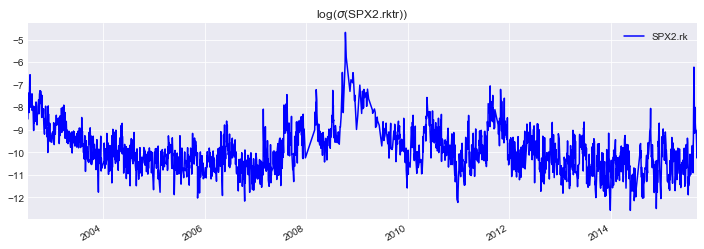

In [24]:
logrv = pd.DataFrame(np.log(rv1[col]))
logrv.plot(color='blue', grid=True, title="log($\sigma$(%str))" %col,figsize=(12, 4));

### Paths of fractional Brownian motion

We simulate the paths of fractional Brownian motion on the same daily time grid as the volatility paths above, in order to visually distinguih the different levels of `roughness' of the paths.
The simulation is performed using Cholesky decomposition, so is slow.

In [21]:
from math import sqrt
from random import gauss
def covFrac(s, t, H): ## covariance function
    return 0.5*(np.power(s,2.*H) + np.power(t,2.*H) - np.power(np.abs(t - s),2.*H))
    
def fbmmatrix(T, nbTimes, H):
    tt = np.linspace(0., T,nbTimes)[1:]

    covMatrixFrac = np.matrix([[covFrac(tt[i], tt[j], H) for j in range(nbTimes-1)] for i in range(nbTimes-1)])
    cholMatFrac = np.linalg.cholesky(covMatrixFrac)
    gaussianVec = np.matrix([np.random.normal(0., 1.) for i in range(nbTimes-1)])

    pathFrac = cholMatFrac * gaussianVec.T
    return np.insert(tt, 0, 0.), np.insert(pathFrac.A1, 0, 0.)

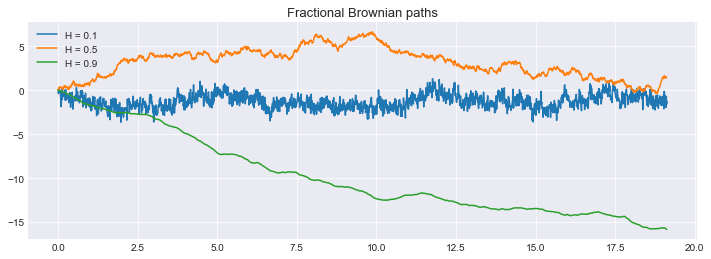

In [22]:
HH = [0.1, 0.5, 0.9]
deltaT = (rv1.index.max() - rv1.index.min()).days / 252.
nbTimes = len(rv1.index)

plt.figure(figsize=(12,4))
for H in HH:
    times, fbm = fbmmatrix(deltaT, nbTimes, H)
    plt.plot(times, fbm, label="H = %.1f" %H)

plt.title("Fractional Brownian paths", fontsize=13)
plt.legend(loc=2)
plt.grid(True)
plt.show()

###Representations of fBm

There are infinitely many possible representations of fBm in terms of Brownian motion.  For example, w


<blockquote><div style="background-color:#003399; color:#FFFFFF; font-style: normal;  " ><h4>
Mandelbrot-Van Ness</h4>
</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>

$$
W^H_t ={C_H}\,\left\{\int_{-\infty}^{t} (t-s)^{H-\frac{1}{2}}dW_s - \int_{-\infty}^{0} (-s)^{H-\frac{1}{2}}dW_s\right\}.
$$
<br>

</div>

</blockquote>

where the choice

$$
C_H = \sqrt{ \frac{2\,H\,\Gamma(3/2-H)}{\Gamma(H+1/2)\,\Gamma(2-2\,H)}}
$$

ensures that

$$
\mathbb{E}\left[W^H_t W^H_s\right] = \frac{1}{2}\,\left\{t^{2 H} + s^{2 H} - |t-s|^{2 H}\right\}.
$$


# Forecasting

In [25]:
import scipy.special as scsp

In [26]:
def c_tilde(h):
    return scsp.gamma(1.5-h) / (scsp.gamma(h+0.5) * scsp.gamma(2.-2.*h))

def forecast_XTS(rvdata, h, date, nLags, delta, nu):
    nLagsRa = np.arange(nLags)
    cf = 1./((nLagsRa+0.5) ** (h+0.5) * (nLagsRa+0.5+delta))
    ldata = rvdata.truncate(after=date)
    ldata = np.log(ldata.iloc[-nLags:])
    ldata['cf'] = np.fliplr([cf])[0]
    ldata = ldata.dropna()
    fcst = (ldata.iloc[:, 0] * ldata['cf']).sum() / sum(ldata['cf']) ## Riemann sum approximation
    return np.exp(fcst + 2.*nu**2. *c_tilde(h)*delta**(2.*h))

In [27]:
idCol = 0
rvdata = pd.DataFrame(rv1[rv1.columns[idCol]])
nu  = Coefdf["nu"][idCol] # Vol of vol estimate for index idCol
h = Coefdf["H"][idCol] # H estimate for index idCol
delta = 1
nLags = 600
dates = rvdata.iloc[nLags:-delta].index
rv_predict = [forecast_XTS(rvdata, h=h, date=d, nLags=nLags, delta=delta, nu=nu) for d in dates]
rv_actual = rvdata.iloc[nLags+delta:].values

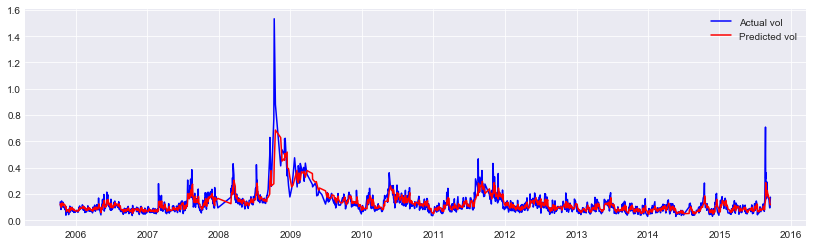

In [28]:
## Plot the annualised volatilities
xx = [d.date() for d in rvdata.index[nLags+delta:]]
N = 2000
xxx = xx[:N]

plt.figure(figsize=(14, 4))
vol_actual = np.sqrt(np.multiply(rv_actual,252.))
vol_predict = np.sqrt(np.multiply(rv_predict,252.))
plt.plot(xxx, vol_actual[:N], "b", label="Actual vol")
plt.plot(xxx, vol_predict[:N], "r", label="Predicted vol")
plt.legend(loc='best')
plt.show()

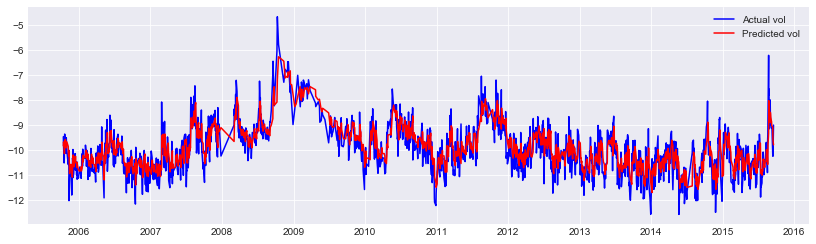

In [26]:
## Plot the log variances
xx = [d.date() for d in rvdata.index[nLags+delta:]]
N = 2000
xxx = xx[:N]

plt.figure(figsize=(14, 4))
vol_actual = np.log(rv_actual)
vol_predict = np.log(rv_predict)
plt.plot(xxx, vol_actual[:N], "b", label="Actual vol")
plt.plot(xxx, vol_predict[:N], "r", label="Predicted vol")
plt.legend(loc='best')
plt.show()